In [2]:
import os
import numpy as np
import scipy.misc
from google.colab import drive
from scipy import datasets

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths (Matches your new project name)
PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"
RAW_DIR = os.path.join(PROJECT_ROOT, "data/raw")
os.makedirs(RAW_DIR, exist_ok=True)

# 3. Load Real ECG Data (MIT-BIH Arrhythmia Database, Record 208)
# This comes built-in with Scipy! No downloads needed.
print("Loading built-in MIT-BIH data...")
ecg_signal = datasets.electrocardiogram()
print("ECG signal shape:", ecg_signal.shape)

# 4. Save it as a raw .npy file
save_path = os.path.join(RAW_DIR, "ecg_raw.npy")
np.save(save_path, ecg_signal)

print(f"✅ Data saved to: {save_path}")
print(f"Signal Shape: {ecg_signal.shape} (Sampling rate: 360Hz)")
print("This represents 5 minutes of real physiological activity.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading built-in MIT-BIH data...
ECG signal shape: (108000,)
✅ Data saved to: /content/drive/MyDrive/MIG_Uncertainty_Project/data/raw/ecg_raw.npy
Signal Shape: (108000,) (Sampling rate: 360Hz)
This represents 5 minutes of real physiological activity.


Signal shape: (108000,)


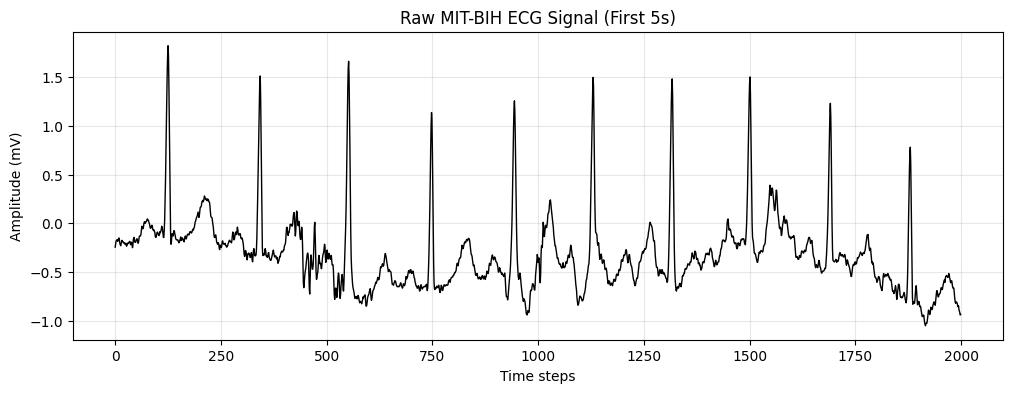

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the path using the variable we just created, or hardcode it
RAW_PATH = "/content/drive/MyDrive/MIG_Uncertainty_Project/data/raw/ecg_raw.npy"

# Load
signal = np.load(RAW_PATH)

print("Signal shape:", signal.shape)

# Visualize first 2000 points (approx 5 seconds)
plt.figure(figsize=(12, 4))
plt.plot(signal[:2000], color='black', lw=1)
plt.title("Raw MIT-BIH ECG Signal (First 5s)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude (mV)")
plt.grid(True, alpha=0.3)
plt.show()

✅ Random Seed fixed at: 42
1️⃣ Loading and Normalizing...
   Original Range: [-3.48, 3.65]
   Norm Range:     [0.00, 1.00]
✅ Normalization parameters saved.
2️⃣ Splitting (Time-series strict):
   Train: 64800
   Val:   21600
   Test:  21600
3️⃣ Segmentation Complete:
   Train Tensor: torch.Size([1009, 1, 256])
   Val Tensor:   torch.Size([334, 1, 256])
   Test Tensor:  torch.Size([84, 1, 256])
4️⃣ Saving to /content/drive/MyDrive/MIG_Uncertainty_Project/data/processed...
✅ Done.


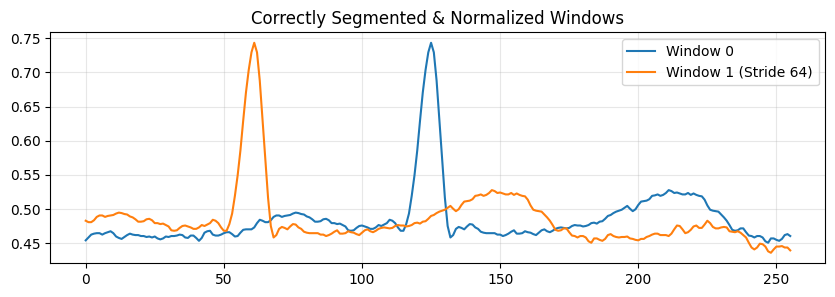

In [4]:
import torch
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"
RAW_PATH = os.path.join(PROJECT_ROOT, "data/raw/ecg_raw.npy")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data/processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"✅ Random Seed fixed at: {SEED}")

# Sampling rate = 360 Hz (from MIT-BIH description)
# WINDOW_SIZE = 256 → ~0.71 seconds per window
# STRIDE = 64 → High overlap to augment training data
WINDOW_SIZE = 256
STRIDE = 64
TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2

# --- 1. LOAD & NORMALIZE ---
print("1️⃣ Loading and Normalizing...")
signal = np.load(RAW_PATH)

# Min-Max Normalization
sig_min = signal.min()
sig_max = signal.max()
signal_norm = (signal - sig_min) / (sig_max - sig_min)

print(f"   Original Range: [{sig_min:.2f}, {sig_max:.2f}]")
print(f"   Norm Range:     [{signal_norm.min():.2f}, {signal_norm.max():.2f}]")

# We need these later to convert predictions back to mV
norm_params = {
    "min": float(sig_min),
    "max": float(sig_max)
}
torch.save(norm_params, os.path.join(PROCESSED_DIR, "normalization.pt"))
print("✅ Normalization parameters saved.")

# --- 2. TIME-SERIES SPLIT ---
total_len = len(signal_norm)
train_end = int(total_len * TRAIN_SPLIT)
val_end = int(total_len * (TRAIN_SPLIT + VAL_SPLIT))

train_signal = signal_norm[:train_end]
val_signal = signal_norm[train_end:val_end]
test_signal = signal_norm[val_end:]

print(f"2️⃣ Splitting (Time-series strict):")
print(f"   Train: {len(train_signal)}")
print(f"   Val:   {len(val_signal)}")
print(f"   Test:  {len(test_signal)}")

# --- 3. WINDOW SEGMENTATION ---
def create_windows(data, window_size, stride):
    windows = []
    for i in range(0, len(data) - window_size, stride):
        window = data[i : i + window_size]
        windows.append(window)
    return np.array(windows)

# Create windows
X_train = create_windows(train_signal, WINDOW_SIZE, STRIDE)
X_val = create_windows(val_signal, WINDOW_SIZE, STRIDE)
# Test set uses non-overlapping windows (stride=window_size) for clean evaluation
X_test = create_windows(test_signal, WINDOW_SIZE, WINDOW_SIZE)

# Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

print(f"3️⃣ Segmentation Complete:")
print(f"   Train Tensor: {X_train_tensor.shape}")
print(f"   Val Tensor:   {X_val_tensor.shape}")
print(f"   Test Tensor:  {X_test_tensor.shape}")

# --- 4. SAVE ---
print(f"4️⃣ Saving to {PROCESSED_DIR}...")
torch.save(X_train_tensor, os.path.join(PROCESSED_DIR, "train_clean.pt"))
torch.save(X_val_tensor, os.path.join(PROCESSED_DIR, "val_clean.pt"))
torch.save(X_test_tensor, os.path.join(PROCESSED_DIR, "test_clean.pt"))
print("✅ Done.")

# --- 5. SANITY PLOT ---
plt.figure(figsize=(10, 3))
plt.plot(X_train_tensor[0, 0, :].numpy(), label="Window 0")
plt.plot(X_train_tensor[1, 0, :].numpy(), label="Window 1 (Stride 64)")
plt.title("Correctly Segmented & Normalized Windows")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()